In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
from PIL import Image
import os
from pathlib import Path
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA L4


In [3]:
def load_and_reduce_mnist(target_class0_count=300):
    """Load MNIST and reduce class 0 to target_class0_count samples"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load full MNIST
    mnist_train = datasets.MNIST('data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST('data', train=False, download=True, transform=transform)
    
    # Get indices for class 0 and other classes
    train_indices_class0 = [i for i, (_, label) in enumerate(mnist_train) if label == 0]
    train_indices_other = [i for i, (_, label) in enumerate(mnist_train) if label != 0]
    
    print(f"Original class 0 samples: {len(train_indices_class0)}")
    
    # Randomly select target_class0_count samples from class 0
    random.seed(42)
    selected_class0 = random.sample(train_indices_class0, target_class0_count)
    
    # Combine with other classes
    final_train_indices = selected_class0 + train_indices_other
    random.shuffle(final_train_indices)
    
    # Create reduced dataset
    reduced_mnist = Subset(mnist_train, final_train_indices)
    
    print(f"Reduced class 0 samples: {target_class0_count}")
    print(f"Total training samples: {len(reduced_mnist)}")
    
    return reduced_mnist, mnist_test

reduced_mnist, mnist_test = load_and_reduce_mnist(300)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.52MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.09MB/s]


Original class 0 samples: 5923
Reduced class 0 samples: 300
Total training samples: 54377


In [4]:
def split_train_val(dataset, val_ratio=0.2):
    """Split dataset into train and validation"""
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    random.seed(42)
    random.shuffle(indices)
    
    split = int(np.floor(val_ratio * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    return train_dataset, val_dataset

train_dataset, val_dataset = split_train_val(reduced_mnist, val_ratio=0.2)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(mnist_test)}")

Train: 43502, Val: 10875, Test: 10000


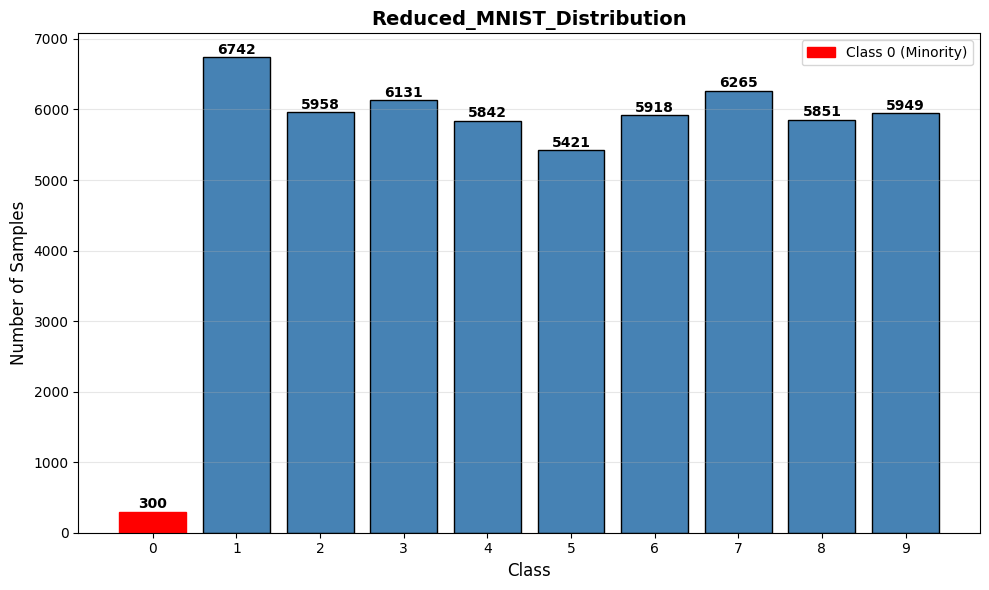


Class Distribution:
Class 0: 300 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


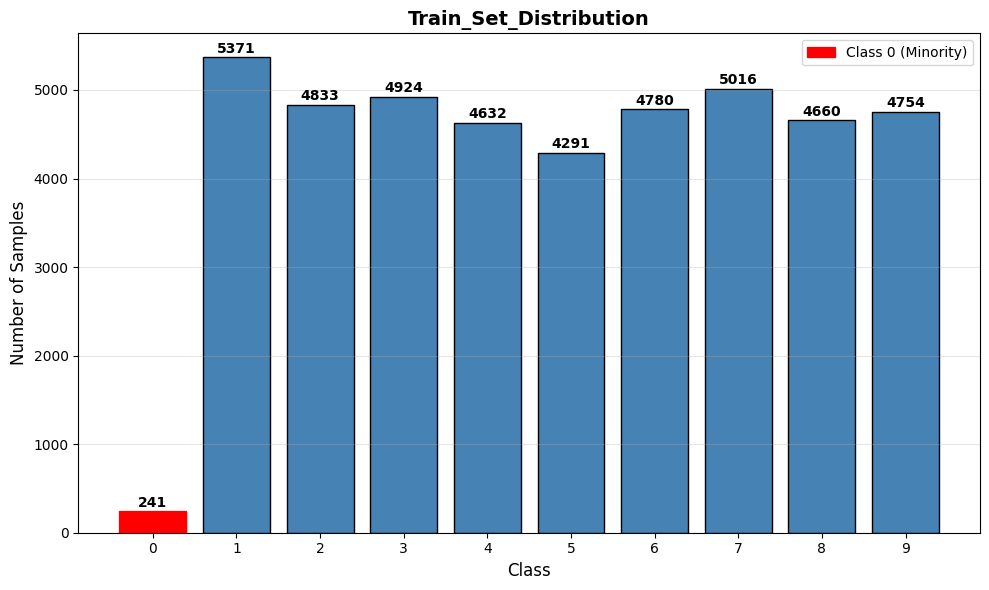


Class Distribution:
Class 0: 241 samples
Class 1: 5371 samples
Class 2: 4833 samples
Class 3: 4924 samples
Class 4: 4632 samples
Class 5: 4291 samples
Class 6: 4780 samples
Class 7: 5016 samples
Class 8: 4660 samples
Class 9: 4754 samples


In [12]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(dataset, title="Class Distribution"):
    """Plot bar chart of class distribution"""
    labels = []
    for _, label in dataset:
        labels.append(label)
    
    class_counts = Counter(labels)
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color='steelblue', edgecolor='black')
    
    # Highlight class 0 in red
    bars[0].set_color('red')
    bars[0].set_label('Class 0 (Minority)')
    
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(classes)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    # Add count labels on bars
    for i, (cls, count) in enumerate(zip(classes, counts)):
        plt.text(cls, count + 50, str(count), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'classifiers_results/{title.replace(" ", "_")}.png', dpi=300)
    plt.show()
    
    print(f"\nClass Distribution:")
    for cls, count in zip(classes, counts):
        print(f"Class {cls}: {count} samples")

# Plot reduced MNIST distribution
plot_class_distribution(reduced_mnist, "Reduced_MNIST_Distribution")

# Plot train split
plot_class_distribution(train_dataset, "Train_Set_Distribution")

In [ ]:
class SyntheticDataset(Dataset):

    def __init__(self, folder_path, label=0):
        self.folder_path = folder_path
        self.label = label
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        return image, self.label

# Load synthetic datasets
vanilla_synthetic = SyntheticDataset('synthetic_data/vanilla_gan', label=0)
dcgan_synthetic = SyntheticDataset('synthetic_data/dcgan', label=0)
cgan_synthetic = SyntheticDataset('synthetic_data/cgan', label=0)

print(f"Vanilla GAN synthetic: {len(vanilla_synthetic)}")
print(f"DCGAN synthetic: {len(dcgan_synthetic)}")
print(f"CGAN synthetic: {len(cgan_synthetic)}")

Vanilla GAN synthetic: 5700
DCGAN synthetic: 5700
CGAN synthetic: 5700


In [6]:
from torch.utils.data import ConcatDataset

# Create 4 training scenarios
train_original = train_dataset
train_vanilla = ConcatDataset([train_dataset, vanilla_synthetic])
train_dcgan = ConcatDataset([train_dataset, dcgan_synthetic])
train_cgan = ConcatDataset([train_dataset, cgan_synthetic])

datasets_dict = {
    'original': train_original,
    'vanilla_gan': train_vanilla,
    'dcgan': train_dcgan,
    'cgan': train_cgan
}

print("\nDataset sizes:")
for name, dataset in datasets_dict.items():
    print(f"{name}: {len(dataset)}")


Dataset sizes:
original: 43502
vanilla_gan: 49202
dcgan: 49202
cgan: 49202


Define the model

In [ ]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 3 * 3) # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
def create_directories():
    """Create necessary directory structure"""
    base_dir = Path('classifiers_results')
    cases = ['original', 'vanilla_gan', 'dcgan', 'cgan']
    
    for case in cases:
        (base_dir / 'saved_models' / case).mkdir(parents=True, exist_ok=True)
        (base_dir / 'saved_training_results' / case).mkdir(parents=True, exist_ok=True)
    
    print("✓ Directory structure created")

create_directories()

✓ Directory structure created


In [9]:
def calculate_metrics(model, dataloader, device):
    """Calculate all metrics for a dataset"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc_roc
    }

In [ ]:
def train_classifier(scenario_name, train_dataset, val_dataset, 
                    start_epoch=1, end_epoch=50, batch_size=64, lr=0.001):
 
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = MNISTClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=3)

    
    # Load previous checkpoint if continuing training
    if start_epoch > 1:
        checkpoint_path = f'classifiers_results/saved_models/{scenario_name}/model_epoch_{start_epoch-1}.pt'
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"✓ Resumed from epoch {start_epoch-1}")
    
    # Results file
    results_file = f'classifiers_results/saved_training_results/{scenario_name}/training_log.txt'
    
    # Training loop
    for epoch in range(start_epoch, end_epoch + 1):
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Calculate metrics
        train_metrics = calculate_metrics(model, train_loader, device)
        val_metrics = calculate_metrics(model, val_loader, device)
        scheduler.step(val_metrics['f1_score'])
        
        # Print results
        print(f"\n{'='*80}")
        print(f"Scenario: {scenario_name.upper()} | Epoch: {epoch}/{end_epoch}")
        print(f"{'='*80}")
        print(f"Train Loss: {avg_train_loss:.4f} | Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"\n{'TRAIN METRICS':<20} | {'VALIDATION METRICS':<20}")
        print(f"{'-'*80}")
        print(f"{'Accuracy:':<15} {train_metrics['accuracy']:.4f}   | {'Accuracy:':<15} {val_metrics['accuracy']:.4f}")
        print(f"{'F1 Score:':<15} {train_metrics['f1_score']:.4f}   | {'F1 Score:':<15} {val_metrics['f1_score']:.4f}")
        print(f"{'Precision:':<15} {train_metrics['precision']:.4f}   | {'Precision:':<15} {val_metrics['precision']:.4f}")
        print(f"{'Recall:':<15} {train_metrics['recall']:.4f}   | {'Recall:':<15} {val_metrics['recall']:.4f}")
        print(f"{'AUC-ROC:':<15} {train_metrics['auc_roc']:.4f}   | {'AUC-ROC:':<15} {val_metrics['auc_roc']:.4f}")
        print(f"{'='*80}\n")
        
        # Save to file
        with open(results_file, 'a') as f:
            if epoch == start_epoch and start_epoch == 1:
                f.write(f"Training Log for {scenario_name}\n")
                f.write(f"{'='*80}\n\n")
            
            f.write(f"Epoch {epoch}/{end_epoch}\n")
            f.write(f"Train Loss: {avg_train_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}\n")
            f.write(f"TRAIN - Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_score']:.4f}, "
                   f"Prec: {train_metrics['precision']:.4f}, Rec: {train_metrics['recall']:.4f}, "
                   f"AUC: {train_metrics['auc_roc']:.4f}\n")
            f.write(f"VAL   - Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_score']:.4f}, "
                   f"Prec: {val_metrics['precision']:.4f}, Rec: {val_metrics['recall']:.4f}, "
                   f"AUC: {val_metrics['auc_roc']:.4f}\n")
            f.write(f"{'-'*80}\n\n")
        
        # Save model
        model_path = f'classifiers_results/saved_models/{scenario_name}/model_epoch_{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        }, model_path)
    
    print(f"✓ Training completed for {scenario_name} (epochs {start_epoch}-{end_epoch})")

# Start Training

In [11]:
# Train original (no synthetic data)
train_classifier('original', datasets_dict['original'], val_dataset, 
                start_epoch=1, end_epoch=20, batch_size=256, lr=0.002)


Scenario: ORIGINAL | Epoch: 1/20
Train Loss: 0.3462

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9779   | Accuracy:       0.9754
F1 Score:       0.9779   | F1 Score:       0.9752
Precision:      0.9782   | Precision:      0.9756
Recall:         0.9779   | Recall:         0.9754
AUC-ROC:        0.9997   | AUC-ROC:        0.9996


Scenario: ORIGINAL | Epoch: 2/20
Train Loss: 0.0743

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9895   | Accuracy:       0.9850
F1 Score:       0.9895   | F1 Score:       0.9850
Precision:      0.9896   | Precision:      0.9851
Recall:         0.9895   | Recall:         0.9850
AUC-ROC:        0.9999   | AUC-ROC:        0.9998


Scenario: ORIGINAL | Epoch: 3/20
Train Loss: 0.0500

TRAIN METRICS        | VALIDATION METRICS  
------------------------------------------

In [16]:
# Train with Vanilla GAN synthetic data
train_classifier('vanilla_gan', datasets_dict['vanilla_gan'], val_dataset, 
                start_epoch=1, end_epoch=20, batch_size=256, lr=0.002)


Scenario: VANILLA_GAN | Epoch: 1/20
Train Loss: 0.2951 | Learning Rate: 0.002000

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9849   | Accuracy:       0.9785
F1 Score:       0.9849   | F1 Score:       0.9785
Precision:      0.9850   | Precision:      0.9786
Recall:         0.9849   | Recall:         0.9785
AUC-ROC:        0.9998   | AUC-ROC:        0.9997


Scenario: VANILLA_GAN | Epoch: 2/20
Train Loss: 0.0688 | Learning Rate: 0.002000

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9907   | Accuracy:       0.9843
F1 Score:       0.9907   | F1 Score:       0.9843
Precision:      0.9908   | Precision:      0.9844
Recall:         0.9907   | Recall:         0.9843
AUC-ROC:        0.9999   | AUC-ROC:        0.9997


Scenario: VANILLA_GAN | Epoch: 3/20
Train Loss: 0.0461 | Learning Rate: 0.002000


In [17]:
# Train with DCGAN synthetic data
train_classifier('dcgan', datasets_dict['dcgan'], val_dataset, 
                start_epoch=1, end_epoch=20, batch_size=256, lr=0.002)


Scenario: DCGAN | Epoch: 1/20
Train Loss: 0.3339 | Learning Rate: 0.002000

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9819   | Accuracy:       0.9789
F1 Score:       0.9819   | F1 Score:       0.9790
Precision:      0.9821   | Precision:      0.9794
Recall:         0.9819   | Recall:         0.9789
AUC-ROC:        0.9997   | AUC-ROC:        0.9996


Scenario: DCGAN | Epoch: 2/20
Train Loss: 0.0707 | Learning Rate: 0.002000

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9901   | Accuracy:       0.9857
F1 Score:       0.9901   | F1 Score:       0.9858
Precision:      0.9901   | Precision:      0.9859
Recall:         0.9901   | Recall:         0.9857
AUC-ROC:        0.9999   | AUC-ROC:        0.9998


Scenario: DCGAN | Epoch: 3/20
Train Loss: 0.0514 | Learning Rate: 0.002000

TRAIN METRICS    

In [18]:
# Train with CGAN synthetic data
train_classifier('cgan', datasets_dict['cgan'], val_dataset, 
                start_epoch=1, end_epoch=20, batch_size=256, lr=0.002)


Scenario: CGAN | Epoch: 1/20
Train Loss: 0.3145 | Learning Rate: 0.002000

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9844   | Accuracy:       0.9801
F1 Score:       0.9844   | F1 Score:       0.9800
Precision:      0.9845   | Precision:      0.9803
Recall:         0.9844   | Recall:         0.9801
AUC-ROC:        0.9998   | AUC-ROC:        0.9997


Scenario: CGAN | Epoch: 2/20
Train Loss: 0.0603 | Learning Rate: 0.002000

TRAIN METRICS        | VALIDATION METRICS  
--------------------------------------------------------------------------------
Accuracy:       0.9881   | Accuracy:       0.9807
F1 Score:       0.9881   | F1 Score:       0.9807
Precision:      0.9883   | Precision:      0.9810
Recall:         0.9881   | Recall:         0.9807
AUC-ROC:        0.9999   | AUC-ROC:        0.9997


Scenario: CGAN | Epoch: 3/20
Train Loss: 0.0432 | Learning Rate: 0.002000

TRAIN METRICS       

# Evaluating on the Testset and comparing the results

In [20]:
def evaluate_on_testset(scenario_name, epoch=20):
    """Load model and evaluate on test set"""
    model = MNISTClassifier().to(device)
    checkpoint = torch.load(f'classifiers_results/saved_models/{scenario_name}/model_epoch_{epoch}.pt', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_loader = DataLoader(mnist_test, batch_size=256, shuffle=False)
    metrics = calculate_metrics(model, test_loader, device)
    
    print(f"{scenario_name.upper():<15} | Acc: {metrics['accuracy']:.4f} | F1: {metrics['f1_score']:.4f} | "
          f"Prec: {metrics['precision']:.4f} | Rec: {metrics['recall']:.4f} | AUC: {metrics['auc_roc']:.4f}")
    
    return metrics

# Evaluate all scenarios
scenarios = ['original', 'vanilla_gan', 'dcgan', 'cgan']
results = {}

print(f"\n{'='*100}")
print(f"TEST SET EVALUATION - Epoch 20")
print(f"{'='*100}")

for scenario in scenarios:
    results[scenario] = evaluate_on_testset(scenario, epoch=20)


TEST SET EVALUATION - Epoch 20
ORIGINAL        | Acc: 0.9914 | F1: 0.9914 | Prec: 0.9914 | Rec: 0.9914 | AUC: 0.9999
VANILLA_GAN     | Acc: 0.9923 | F1: 0.9923 | Prec: 0.9923 | Rec: 0.9923 | AUC: 1.0000
DCGAN           | Acc: 0.9915 | F1: 0.9915 | Prec: 0.9915 | Rec: 0.9915 | AUC: 0.9999
CGAN            | Acc: 0.9912 | F1: 0.9912 | Prec: 0.9912 | Rec: 0.9912 | AUC: 0.9999


/var/tmp/ipykernel_235834/2475494121.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(scenarios, rotation=15)


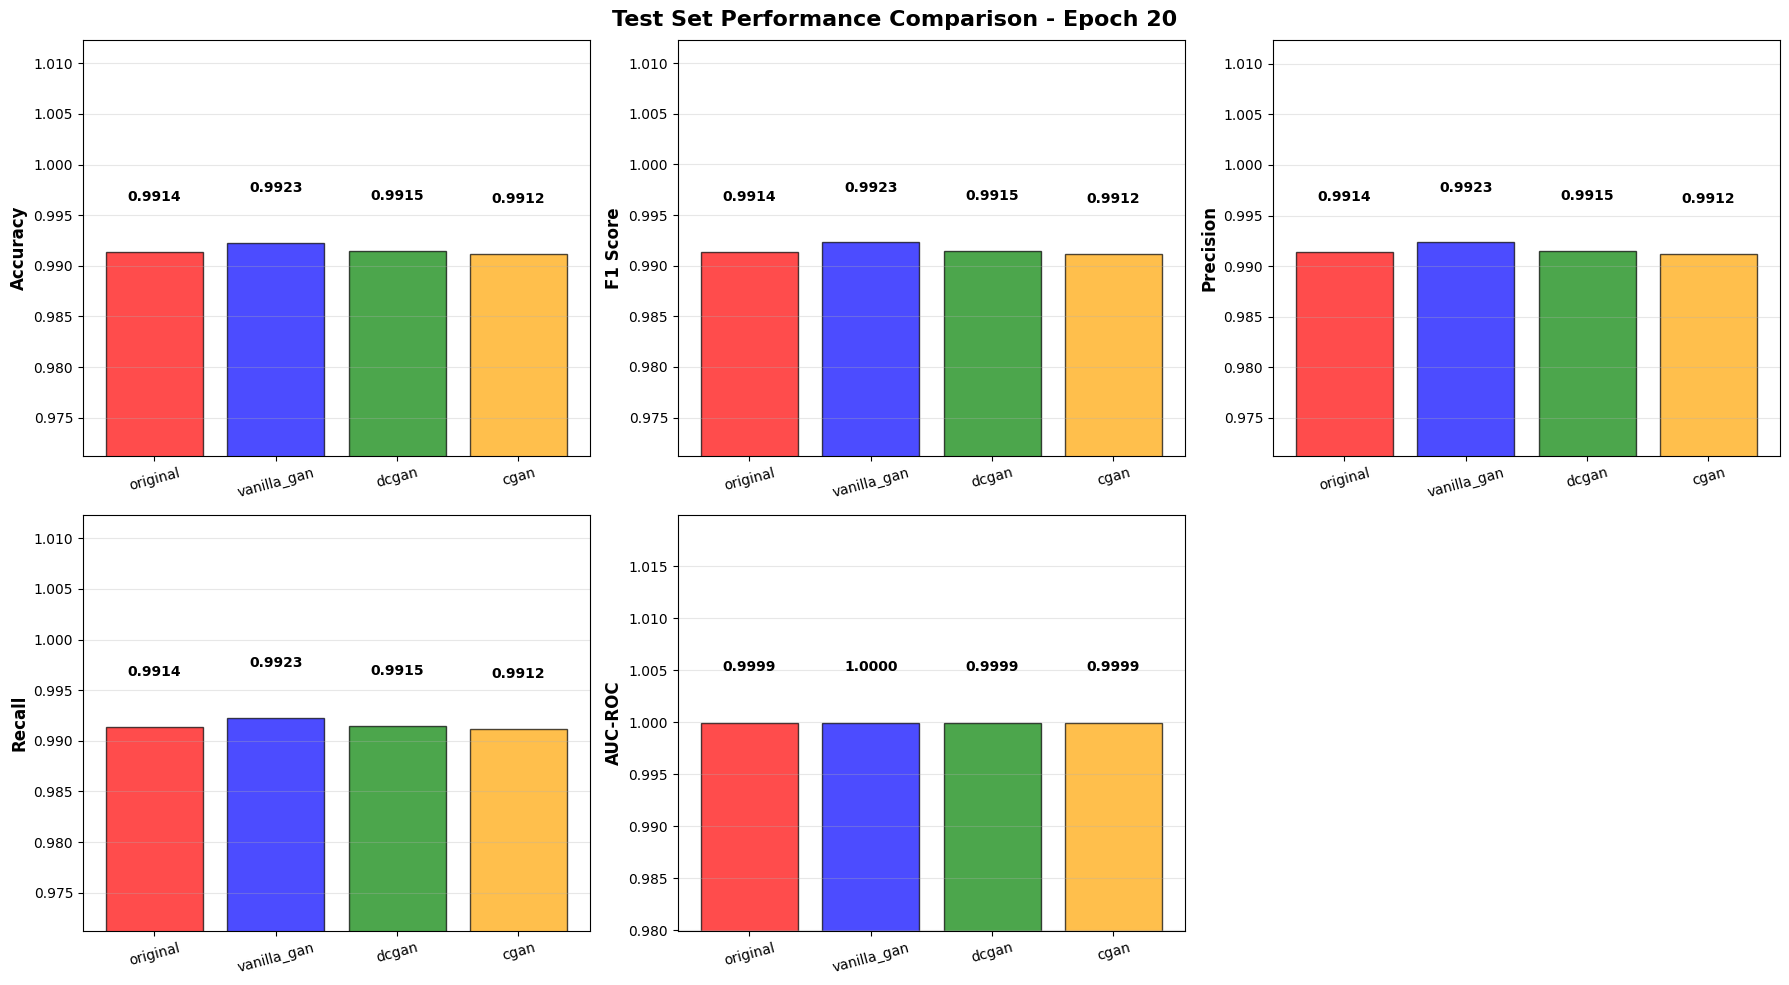

In [21]:
# Comparison bar plots
import matplotlib.pyplot as plt
import numpy as np

metrics_names = ['accuracy', 'f1_score', 'precision', 'recall', 'auc_roc']
metric_labels = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (metric, label) in enumerate(zip(metrics_names, metric_labels)):
    values = [results[s][metric] for s in scenarios]
    colors = ['red', 'blue', 'green', 'orange']
    
    bars = axes[idx].bar(scenarios, values, color=colors, edgecolor='black', alpha=0.7)
    axes[idx].set_ylabel(label, fontsize=12, fontweight='bold')
    axes[idx].set_ylim([min(values) - 0.02, max(values) + 0.02])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticklabels(scenarios, rotation=15)
    
    # Add value labels
    for bar, val in zip(bars, values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                      f'{val:.4f}', ha='center', fontsize=10, fontweight='bold')

axes[5].axis('off')  # Remove last empty subplot

plt.suptitle('Test Set Performance Comparison - Epoch 20', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('classifiers_results/test_set_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Summary table
import pandas as pd

df = pd.DataFrame(results).T
df.columns = metric_labels
df.index.name = 'Scenario'

print("\n" + "="*100)
print("SUMMARY TABLE - Test Set Results")
print("="*100)
print(df.to_string())
print("="*100)

df.to_csv('classifiers_results/test_set_results.csv')


SUMMARY TABLE - Test Set Results
             Accuracy  F1 Score  Precision  Recall   AUC-ROC
Scenario                                                    
original       0.9914  0.991389   0.991437  0.9914  0.999944
vanilla_gan    0.9923  0.992294   0.992334  0.9923  0.999953
dcgan          0.9915  0.991497   0.991531  0.9915  0.999921
cgan           0.9912  0.991190   0.991233  0.9912  0.999938


In [25]:
# Per-class accuracy (detailed analysis)
from sklearn.metrics import confusion_matrix, classification_report

def detailed_per_class_analysis(scenario_name, epoch=20):
    """Detailed per-class metrics"""
    model = MNISTClassifier().to(device)
    checkpoint = torch.load(f'classifiers_results/saved_models/{scenario_name}/model_epoch_{epoch}.pt', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    test_loader = DataLoader(mnist_test, batch_size=256, shuffle=False)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    print(f"\n{'='*80}")
    print(f"Classification Report - {scenario_name.upper()}")
    print(f"{'='*80}")
    print(classification_report(all_labels, all_preds, digits=4))
    
    return confusion_matrix(all_labels, all_preds)

# Run for all scenarios
conf_matrices = {}
for scenario in scenarios:
    conf_matrices[scenario] = detailed_per_class_analysis(scenario, epoch=20)


Classification Report - ORIGINAL
              precision    recall  f1-score   support

           0     0.9969    0.9704    0.9835       980
           1     0.9947    1.0000    0.9974      1135
           2     0.9932    0.9971    0.9952      1032
           3     0.9941    0.9960    0.9951      1010
           4     0.9889    0.9939    0.9914       982
           5     0.9933    0.9922    0.9927       892
           6     0.9824    0.9916    0.9870       958
           7     0.9971    0.9922    0.9946      1028
           8     0.9818    0.9969    0.9893       974
           9     0.9910    0.9822    0.9866      1009

    accuracy                         0.9914     10000
   macro avg     0.9913    0.9913    0.9913     10000
weighted avg     0.9914    0.9914    0.9914     10000


Classification Report - VANILLA_GAN
              precision    recall  f1-score   support

           0     0.9990    0.9745    0.9866       980
           1     0.9956    0.9982    0.9969      1135
       

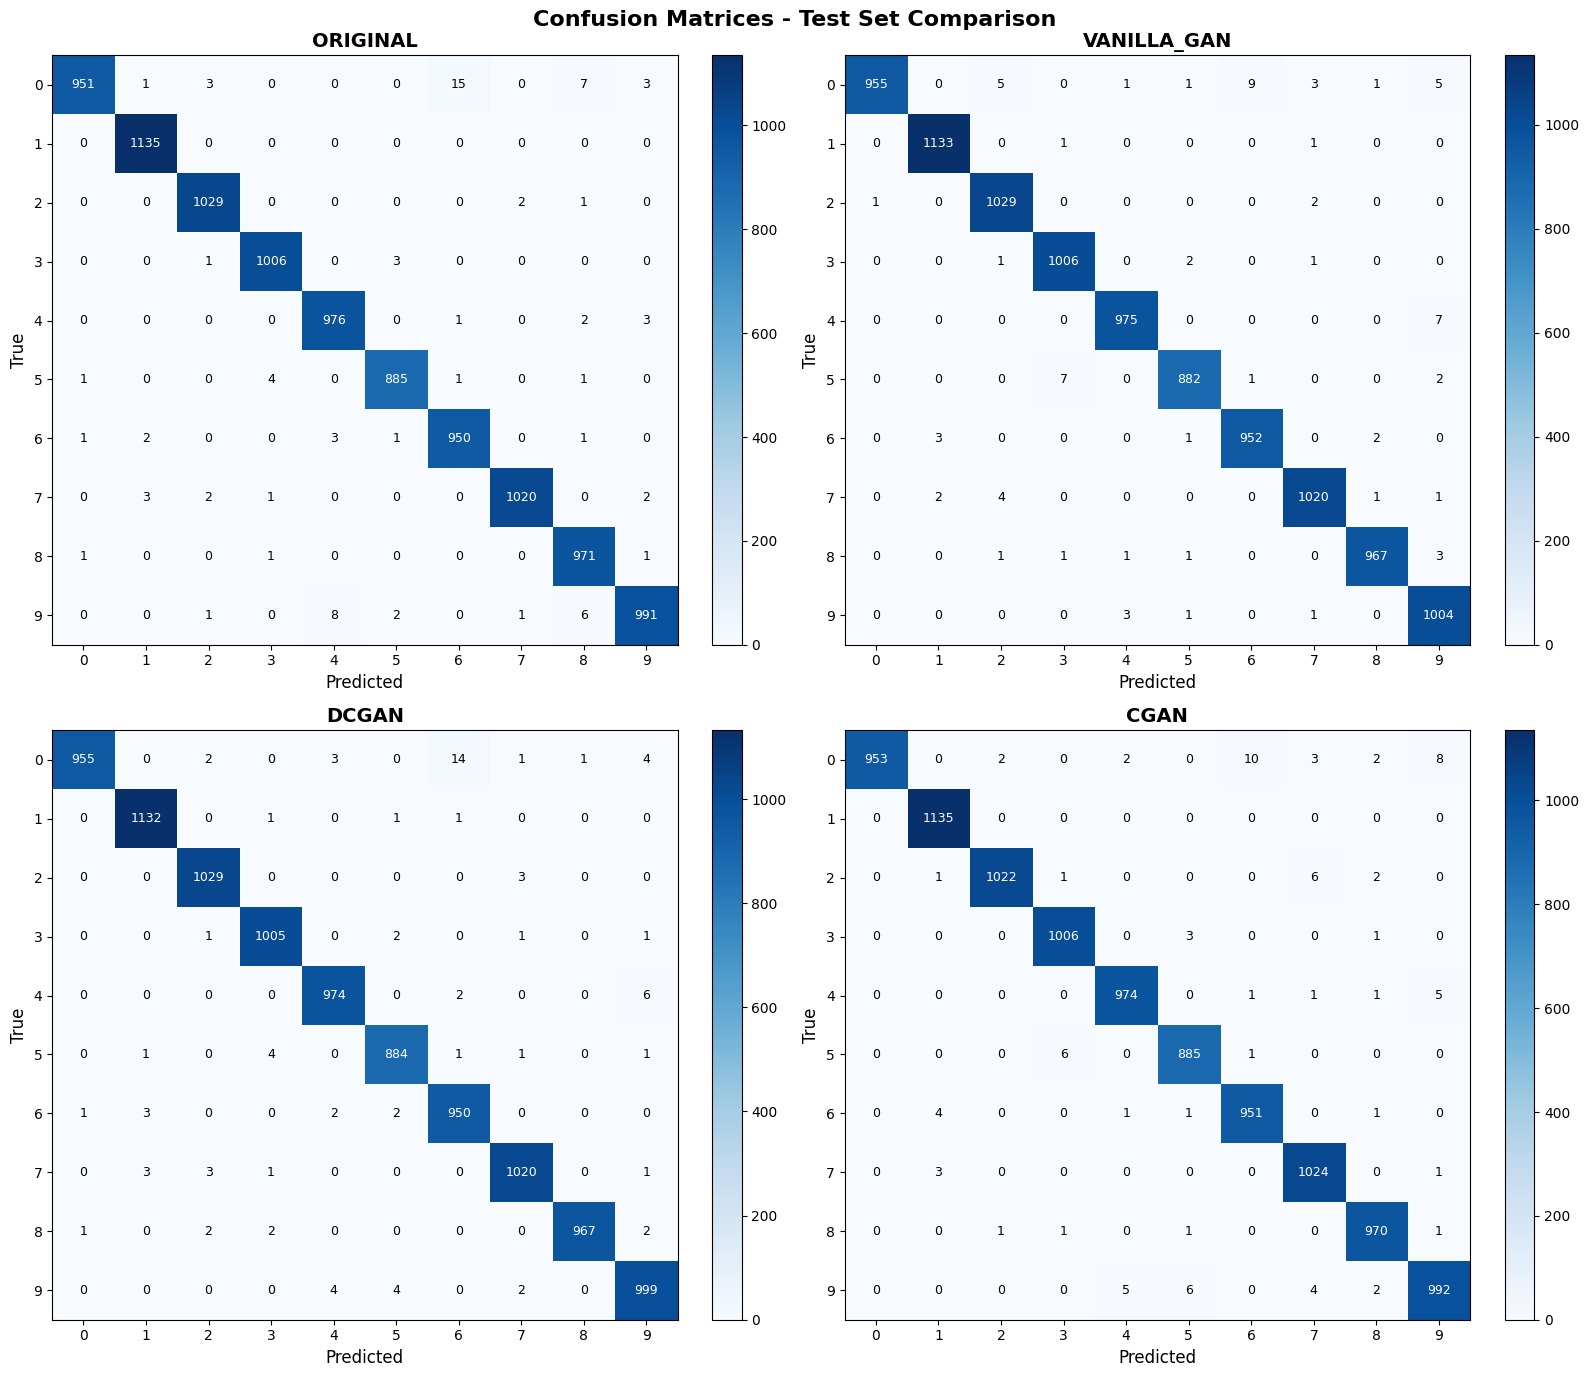

In [26]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, scenario in enumerate(scenarios):
    cm = conf_matrices[scenario]
    im = axes[idx].imshow(cm, cmap='Blues', aspect='auto')
    axes[idx].set_title(f'{scenario.upper()}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=12)
    axes[idx].set_ylabel('True', fontsize=12)
    axes[idx].set_xticks(range(10))
    axes[idx].set_yticks(range(10))
    
    # Add text annotations
    for i in range(10):
        for j in range(10):
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            axes[idx].text(j, i, str(cm[i, j]), ha='center', va='center', 
                          color=text_color, fontsize=9)
    
    plt.colorbar(im, ax=axes[idx], fraction=0.046)

plt.suptitle('Confusion Matrices - Test Set Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('classifiers_results/confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Class 0 specific analysis
print("\n" + "="*100)
print("CLASS 0 (MINORITY) SPECIFIC ANALYSIS")
print("="*100)

for scenario in scenarios:
    cm = conf_matrices[scenario]
    class0_precision = cm[0, 0] / cm[:, 0].sum()
    class0_recall = cm[0, 0] / cm[0, :].sum()
    class0_f1 = 2 * (class0_precision * class0_recall) / (class0_precision + class0_recall)
    
    print(f"{scenario.upper():<15} | Precision: {class0_precision:.4f} | "
          f"Recall: {class0_recall:.4f} | F1: {class0_f1:.4f}")


CLASS 0 (MINORITY) SPECIFIC ANALYSIS
ORIGINAL        | Precision: 0.9969 | Recall: 0.9704 | F1: 0.9835
VANILLA_GAN     | Precision: 0.9990 | Recall: 0.9745 | F1: 0.9866
DCGAN           | Precision: 0.9979 | Recall: 0.9745 | F1: 0.9861
CGAN            | Precision: 1.0000 | Recall: 0.9724 | F1: 0.9860
